<a href="https://colab.research.google.com/github/nicoeiris11/NLP-semantic-search/blob/main/SemanticSearch_Movies_NicolasEiris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check if can access data from the notebook



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls /content/drive/'My Drive'/'wiki_movie_plots_deduped_with_summaries.csv'
dataset_path = "/content/drive/My Drive/wiki_movie_plots_deduped_with_summaries.csv"

'/content/drive/My Drive/wiki_movie_plots_deduped_with_summaries.csv'


# Imports

In [141]:
!pip install transformers
!pip install faiss-gpu

import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
import faiss
import time
from tqdm import tqdm
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data loading & analysis

This first part of the notebook have the following purposes:
- Load data
- Analyze
  - Size of dataset
  - Explore the data to gain insights and understanding of the movie plots and plot
  - Perform any necessary data cleaning and preprocessing you find necessary.

Before working on the indexing and NLP model, it is very important to really understand the data we are working with. If we do not analyze data and pre-process it correctly, final accuracy will likely be lower than it could be.

In [150]:
df = pd.read_csv(dataset_path)

pd.set_option('display.width', 200)
# Display the first few rows of the DataFrame
print(df.head(3))

   Release Year                          Title Origin/Ethnicity Director Cast    Genre                                          Wiki Page                                               Plot  \
0          1901         Kansas Saloon Smashers         American  Unknown  NaN  unknown  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...  A bartender is working at a saloon, serving dr...   
1          1901  Love by the Light of the Moon         American  Unknown  NaN  unknown  https://en.wikipedia.org/wiki/Love_by_the_Ligh...  The moon, painted with a smiling face hangs ov...   
2          1901        The Martyred Presidents         American  Unknown  NaN  unknown  https://en.wikipedia.org/wiki/The_Martyred_Pre...  The film, just over a minute long, is composed...   

                                         PlotSummary  
0  Carrie Nation and her followers burst into a s...  
1  The moon, painted with a smiling face hangs ov...  
2  The film, just over a minute long, is composed...  


In [151]:
# Columns types
print("Data types:")
print(df.dtypes)

Data types:
Release Year         int64
Title               object
Origin/Ethnicity    object
Director            object
Cast                object
Genre               object
Wiki Page           object
Plot                object
PlotSummary         object
dtype: object


In [152]:
# DF info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
 8   PlotSummary       34886 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.4+ MB
None


In [153]:
# Missing values
print(df.isna().sum())

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
PlotSummary            0
dtype: int64


There are no missing values for "Plot" and "PlotSummary" columns.

### Let's analyze duplicates and both columns length distribution. Before that, let's just sample some data points and see the nature of the data to possibly detect data cleaning steps...

In [154]:
df[['Plot', 'PlotSummary']].sample(4)

,Plot,PlotSummary
20370,"Mr. Neville (Anthony Higgins), a young and arr...",Mr. Neville (Anthony Higgins) is contracted to...
24368,"The story revolves around a farmer, Shambu Mah...","The story revolves around a farmer, Shambu Mah..."
21671,Billy Moore (Joe Cole) is sent to prison in Th...,Billy Moore (Joe Cole) is sent to prison in Th...
33929,"The story revolves around Kako Motoya, a first...","The story revolves around Kako Motoya, a first..."


### Check duplicated rows

In [155]:
df[df.duplicated(subset=['Plot', 'PlotSummary'])].head(3)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,PlotSummary
286,1919,Nine-Tenths of the Law,American,B. Reeves Eason,"Mitchell Lewis, Jimsy Maye",drama,https://en.wikipedia.org/wiki/Nine-Tenths_of_t...,"As described in a film magazine,[1] Jules Lene...","Jules Leneau (Lewis) and his wife Jane (Maye),..."
370,1921,Among Those Present,American,Fred C. Newmeyer,Harold Lloyd,comedy,https://en.wikipedia.org/wiki/Among_Those_Present,Mrs. O'Brien (Herring) is eager to be accepted...,Mrs. O'Brien (Herring) hosts a fox hunt as par...
400,1921,Now or Never,American,"Fred C. Newmeyer, Hal Roach","Harold Lloyd, Mildred Davis",comedy,https://en.wikipedia.org/wiki/Now_or_Never_(19...,"A young woman, who is employed as a nanny to a...",A young woman takes a young nanny to a lonesom...


In [156]:
df[df["Plot"] == df.iloc[286]["Plot"]]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,PlotSummary
227,1918,Nine-Tenths of the Law,American,B. Reeves Eason,Mitchell Lewis,drama,https://en.wikipedia.org/wiki/Nine-Tenths_of_t...,"As described in a film magazine,[1] Jules Lene...","Jules Leneau (Lewis) and his wife Jane (Maye),..."
286,1919,Nine-Tenths of the Law,American,B. Reeves Eason,"Mitchell Lewis, Jimsy Maye",drama,https://en.wikipedia.org/wiki/Nine-Tenths_of_t...,"As described in a film magazine,[1] Jules Lene...","Jules Leneau (Lewis) and his wife Jane (Maye),..."


In [157]:
print(f"Number of duplicated rows: {len(df[df.duplicated(subset=['Plot', 'PlotSummary'])])}")

print(f"DF length before duplicates removal: {len(df)}")
df = df.drop_duplicates(subset=['Plot', 'PlotSummary'])
print(f"DF length after duplicates removal: {len(df)}")

Number of duplicated rows: 1017
DF length before duplicates removal: 34886
DF length after duplicates removal: 33869


### Let's check rows where PlotSummary = Plot

In [158]:
summ_equals_plot_mask = df['Plot'] == df['PlotSummary']
summ_equals_plot = df[summ_equals_plot_mask]
print("# of rows were Summary equals Plot:", len(summ_equals_plot))
summ_equals_plot.head(3)[['Plot', 'PlotSummary']]

# of rows were Summary equals Plot: 121


,Plot,PlotSummary
120,A young sculptor searches for the perfect mode...,A young sculptor searches for the perfect mode...
385,Buster plays a drifter who cons his way into w...,Buster plays a drifter who cons his way into w...
441,Chaplin plays a laborer on a house constructio...,Chaplin plays a laborer on a house constructio...


In [159]:
# Let's make the Plot empty for rows where Plot equals Summary
df.loc[summ_equals_plot_mask, 'Plot'] = ''
df[df['Plot'] == df['PlotSummary']].head(3)[['Plot', 'PlotSummary']]

,Plot,PlotSummary


### Let's check rows where PlotSummary starts with Plot content and viceversa

In [160]:
summ_starts_w_plot_mask = df.apply(lambda row: row['PlotSummary'].startswith(row['Plot']), axis=1)
summ_starts_w_plot = df[summ_starts_w_plot_mask]
print("# of rows were Summary starts with Plot:", len(summ_starts_w_plot))
summ_starts_w_plot.head(3)[['Plot', 'PlotSummary']]

# of rows were Summary starts with Plot: 935


,Plot,PlotSummary
11,The film features a train traveling through th...,The film features a train traveling through th...
43,The story concerns a soldier who deserts his r...,The story concerns a soldier who deserts his r...
52,Barney Oldfield races a speeding locomotive to...,Barney Oldfield races a speeding locomotive to...


In [161]:
plot_starts_w_summ_mask = df.apply(lambda row: row['Plot'].startswith(row['PlotSummary']), axis=1)
plot_starts_w_summ = df[plot_starts_w_summ_mask]
print("# of rows were Plot starts with Summary:", len(plot_starts_w_summ))
plot_starts_w_summ.head(3)[['Plot', 'PlotSummary']]

# of rows were Plot starts with Summary: 387


,Plot,PlotSummary
1,"The moon, painted with a smiling face hangs ov...","The moon, painted with a smiling face hangs ov..."
38,The story deals with Tom Brown's efforts to sa...,The story deals with Tom Brown's efforts to sa...
46,The film is about a poor married couple living...,The film is about a poor married couple living...


In [163]:
starts_with_inner_join = pd.merge(summ_starts_w_plot, plot_starts_w_summ, left_index=True, right_index=True, how='inner')
print("# of rows with same Plot and Summary (expected 0): ", len(starts_with_inner_join))
starts_with_inner_join.head(3)[['Plot_x', 'PlotSummary_x']]

# of rows with same Plot and Summary (expected 0):  0


,Plot_x,PlotSummary_x


In [164]:
# Let's make the Plot empty for rows where Summary starts with Plot
df.loc[summ_starts_w_plot_mask, 'Plot'] = ''

# Let's make the Summary empty for rows where Plot starts PlotSummary starts with Plot
df.loc[plot_starts_w_summ_mask, 'PlotSummary'] = ''

### Plot and Summary length analysis

In [165]:
plot_length = df['Plot'].apply(lambda x: len(x.split()))
print("Statistics of plot lengths:")
print(plot_length.describe())

Statistics of plot lengths:
count    33869.000000
mean       369.810859
std        314.139920
min          0.000000
25%        121.000000
50%        282.000000
75%        577.000000
max       6752.000000
Name: Plot, dtype: float64


<Axes: >

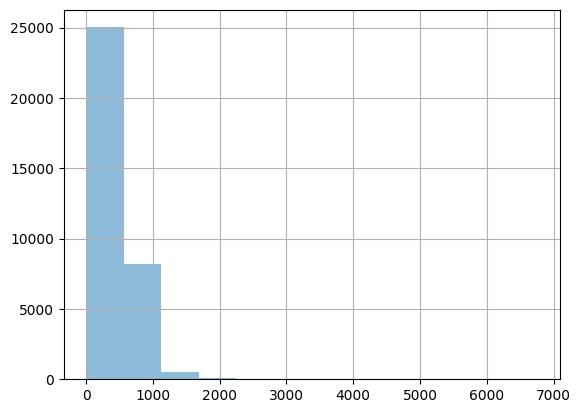

In [166]:
plot_length.hist(bins=12, alpha=0.5)

Extremely short texts might not provide enough context for meaningful analysis or semantic search. Such short texts might not generate reliable embeddings for comparison in the future.

Long texts could impact processing time and memory usage, as well as the quality of embeddings.

Given I'll experiment with BERT which provides truncation + padding out of the box and the vector fixed size is 512 for each token, I'll experiment discarding rows where text length is greater than 1024 (auto padding for < 512 and auto truncation for > 512 vectors)

In [167]:
plot_length_summ = df['PlotSummary'].apply(lambda x: len(x.split()))
print("Statistics of plot summary lengths:")
print(plot_length_summ.describe())

Statistics of plot summary lengths:
count    33869.000000
mean        64.602852
std         18.037321
min          0.000000
25%         52.000000
50%         62.000000
75%         77.000000
max        116.000000
Name: PlotSummary, dtype: float64


<Axes: >

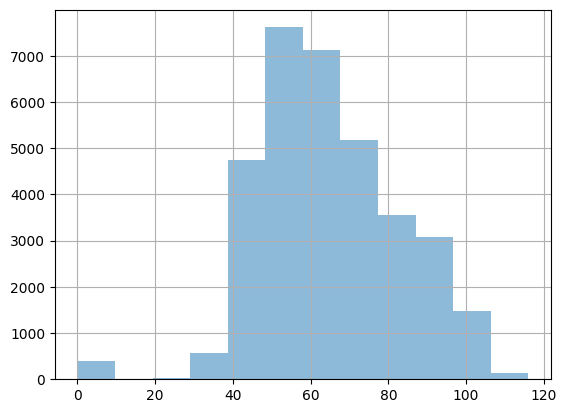

In [168]:
plot_length_summ.hist(bins=12, alpha=0.5)

This other column seems to have a more consistent distribution in terms of length.

Based on the assignment specification, the expectation is to implement a single index that can handle both "Plot" and "PlotSummary" embeddings. The purpose of the semantic search is to find the most relevant movie plots and plot summaries based on a generic user query. This implies that the intention is to use a unified approach to create embeddings for both columns and use a single index for querying. That's why the next step is to create a column concatenating both text columns.

Another approach is to have 2 indexes (one for each column and query by "Plot" or "PlotSummary", which would provide the following benefits (but would imply querying buy specific columns):

- Semantic Differences: "Plot" and "PlotSummary" may have distinct semantic characteristics. By using separate indexes, we can capture and leverage these differences to improve search accuracy.

- Optimized Search: Separate indexes can be optimized individually. This can lead to more efficient searches and better retrieval of relevant results.

- Flexibility: With separate indexes, we have the flexibility to fine-tune parameters, normalization, and other settings specifically for each type of data (if we decide to fine-tune the pretrained model).

- Future Extensions: If we plan to incorporate additional types of data in the future, having separate indexes can accommodate such changes, favoring scalability and maintenance of the pipeline.



### Traditional NLP pre-processing

Even modern tokenizers handles most of the preproc steps I'd like to share the typical cleaning steps for tokenizing cleaned text data points.

In [169]:
df['PlotSummary_Plot'] = df['PlotSummary'] + " " + df['Plot']

In [170]:
df[['PlotSummary_Plot', 'Plot', 'PlotSummary']].head(2)

,PlotSummary_Plot,Plot,PlotSummary
0,Carrie Nation and her followers burst into a s...,"A bartender is working at a saloon, serving dr...",Carrie Nation and her followers burst into a s...
1,"The moon, painted with a smiling face hangs o...","The moon, painted with a smiling face hangs ov...",


As we can see in row 0, the concatenated column have repeated sentences (e.g "The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register.")

Let's dedup repeteaded sentences using nltk lib.

In [171]:
def deduplicate_sentences(text):
    sentences = sent_tokenize(text)
    unique_sentences = list(dict.fromkeys(sentences))
    cleaned_text = " ".join(unique_sentences)
    return cleaned_text

# Apply sentence dedupliction to 'Plot_PlotSummary' column
df['Cleaned_PlotSummary_Plot'] = df['PlotSummary_Plot'].apply(deduplicate_sentences)

In [172]:
# Initialize NLTK Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()

    # Remove special charcters and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = text.split()

    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Reconstruct the cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Apply NLP preproc to 'Cleaned_PlotSummary_Plot' column
df['Cleaned_PlotSummary_Plot'] = df['Cleaned_PlotSummary_Plot'].apply(preprocess_text)


In [173]:
df = df[['Cleaned_PlotSummary_Plot', 'PlotSummary_Plot', 'Plot', 'PlotSummary']]

In [174]:
df.sample(2)

,Cleaned_PlotSummary_Plot,PlotSummary_Plot,Plot,PlotSummary
19474,matt kirk three accomplice take refuge fort de...,Matt Kirk and his three accomplices take refug...,"An ambulance drives through Sydney, having bee...",Matt Kirk and his three accomplices take refug...
2244,film set mid late 19th century depicts émile z...,The film is set in the mid through late 19th c...,"Set in the mid through late 19th century, it d...",The film is set in the mid through late 19th c...


As a first step I'll use the data points where after concatenation the length is < 1024 for the similarity search and evaluate results. Given the model I pretend to use (BERT) tokenizes the text using a vector of 512, given it automatically truncates and pads the text, I'd like to experiment using this filter to speed up execution time of tokenization.


In [175]:
cleaned_length = df['Cleaned_PlotSummary_Plot'].apply(lambda x: len(x.split()))
print("Statistics of cleaned concatenated lengths:")
print(cleaned_length.describe())

Statistics of cleaned concatenated lengths:
count    33869.000000
mean       232.231893
std        176.752179
min         16.000000
25%         90.000000
50%        183.000000
75%        352.000000
max       3614.000000
Name: Cleaned_PlotSummary_Plot, dtype: float64


In [176]:
count_above_1024 = (cleaned_length > 1024).sum()
print(f"Number of rows with concat length > 1024: {count_above_1024}")

Number of rows with concat length > 1024: 80


In [177]:
max_word_count = 1024
print(f"DF length before filtering", len(df))
df = df[df['Cleaned_PlotSummary_Plot'].apply(lambda x: len(x.split())) <= max_word_count]
df = df.reset_index(drop=True)  # Reset index and drop the old index column
print(f"DF length after filtering", len(df))

DF length before filtering 33869
DF length after filtering 33789


# Semantic Search with FAISS


## Model selection

BERT (Bidirectional Encoder Representations from Transformers) is chosen for this task because of its pre-trained nature and contextual understanding of language. BERT-based models have demonstrated exceptional performance in various NLP tasks, including semantic similarity and search. By pre-training on a large corpus, BERT learns rich word representations that capture semantic meaning, context, and relationships.

In our case, we're dealing with text data that requires capturing the inner understanding of movie plots and summaries. BERT's bidirectional architecture allows it to understand the context of each word in relation to the entire sentence (also, attention based model). Additionally, BERT's embeddings are particularly well-suited for semantic search tasks, as they encode high-level features that represent the underlying semantics of the text.

Using BERT embeddings, we can create meaningful representations of both "Plot" and "PlotSummary" text data, enabling accurate semantic similarity calculations for our searches.

Let's try with BERT and then analyze other alternatives (additional questions section).

In [178]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [179]:
# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)

In [180]:
def create_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad(): # Don't want to compute gradients since I'm in inference phase
        inputs.to('cuda')
        output = model(**inputs)  # Forward pass through the BERT model by unpacking inputs dict to key-val format

    return output.pooler_output.cpu().numpy()  # Return the pooled output embeddings


In [181]:
# Batch processing and profiling
batch_size = 64
total_rows = len(df)
num_batches = (total_rows + batch_size - 1) // batch_size

# Initialize the combined embeddings array
combined_embeddings = []

start_time = time.time()

# Process data in batches using tqdm for progress tracking
for batch_idx in tqdm(range(num_batches), desc="Processing batches"):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, total_rows)
    batch_data = df['Cleaned_PlotSummary_Plot'][start_idx:end_idx]

    # Create embeddings for the current batch
    batch_embeddings = np.array([create_embeddings(text) for text in batch_data])
    combined_embeddings.append(batch_embeddings)

# concatenates batches results along rows, and then removes any singleton dimensions, resulting in a flattened array
combined_embeddings = np.concatenate(combined_embeddings, axis=0).squeeze()

end_time = time.time()
print(f"\nTime taken for embedding generation: {end_time - start_time:.2f} seconds")


Processing batches: 100%|██████████| 528/528 [15:27<00:00,  1.76s/it]


Time taken for embedding generation: 927.05 seconds


In [182]:
combined_embeddings.shape

(33789, 768)

In [183]:
# Define the path to save the file
save_path = '/content/drive/My Drive/combined_embeddings_movies.npy'

# Save the combined_embeddings array
np.save(save_path, combined_embeddings)

In [184]:
# load_path = '/content/drive/My Drive/combined_embeddings_movies.npy'

# # Load the combined_embeddings array
# loaded_embeddings = np.load(load_path)

In [185]:
# Normalize embeddings using L2 normalization
faiss.normalize_L2(combined_embeddings)

In [186]:
# Create a single FAISS index for 'Plot_PlotSummary' embeddings
index = faiss.IndexFlatIP(combined_embeddings.shape[1])
index.add(combined_embeddings)

In [192]:
# Function to perform semantic search using a given query
def semantic_search(query, index):
    query_embedding = create_embeddings(query)
    faiss.normalize_L2(query_embedding)

    # Perform similarity search using the FAISS index
    D, I = index.search(query_embedding, k=5)  # Return top 5 most similar indices
    return I

In [197]:
example_queries = ["action-packed adventure", "romantic love story", "mystery thriller"]
search_times = []

for query in example_queries:
    start_time = time.time()
    similar_indices = semantic_search(query, index)
    end_time = time.time()

    # Track time
    search_time = end_time - start_time
    search_times.append(search_time)

    # Access the rows using Pandas indexing
    similar_plots = df.iloc[similar_indices[0]]['Plot']
    similar_plot_summaries = df.iloc[similar_indices[0]]['PlotSummary']

    # Print the results
    print("\n-----> Query:", query)
    print("\n ** Top similar plots and plot summaries:")
    for i, (plot, summary) in enumerate(zip(similar_plots, similar_plot_summaries)):
        print(f"\nResult {i+1}:\nPlot: {plot}\nSummary: {summary}\n")

    print(f"Search Time: {search_time:.4f} seconds \n\n")


# Calculate average search time
average_search_time = sum(search_times) / len(search_times)
print(f"Average Search Time: {average_search_time:.4f} seconds")


-----> Query: action-packed adventure

 ** Top similar plots and plot summaries:

Result 1:
Plot: The film is "(a) tale of chivalry in modern times, involving a Glasgow grocer and a Russian princess imprisoned in a deserted castle" according to the British Film Institute.[3]
Summary: The film is "(a) tale of chivalry in modern times, involving a Glasgow grocer and a Russian princess imprisoned in a deserted castle" according to the British Film Institute. The film was "a tale of (chivalry in) modern times" involving a Scottish grocer and Russian princess.


Result 2:
Plot: The story revolves around three love stories that run simultaneously. The background of the movie is a construction of a crossroads with 4 roads and all people are related to the road that is being built and are involved. How the love stories unfold forms the crux of the movie.
Summary: The story revolves around three love stories that run simultaneously. The background of the movie is a construction of a crossroads

# Additional questions

## Explain your choice of the Hugging Faces model for creating embeddings and its suitability for this task.

[BERT](https://arxiv.org/abs/1810.04805) is an excellent choice for generating embeddings in the context of semantic similarity search due to its exceptional natural language understanding capabilities. BERT, which stands for Bidirectional Encoder Representations from Transformers, has been trained on massive amounts of text data, enabling it to comprehend the complex structures of natural language.

When applied to the task of creating embeddings for movie plots and summaries, BERT effectively translates textual content into dense representations that encapsulate the semantic meaning of the text. BERT's differencial vs. traditional NLP models lies in the attention mechanism, a component of the Transformer architecture, which enables it to identify and weight the importance of individual words and their contextual relationships within a sentence.

In the context of semantic similarity search, BERT embeddings serve as a great tool for measuring the semantic distance between different movie plots and summaries. Given that BERT's embeddings encode semantic meaning, they provide a reliable basis for identifying similarities that extend beyond keyword matches. This results in a more robust and accurate similarity search, enabling to retrieve movies that share conceptual similarities.


## Explore how Language Models (LLMs) like GPT or LLama could potentially improve the semantic search performance and explain the possible benefits.

Integrating models like GPT or LLama into the solution could improve semantic search results. These LLMs are great in generating contextually accurate language representations. By fine-tuning these models on movie plots and summaries, we could create embeddings that capture more relationships vs. BERT tokens. This would lead to improved accuracy in similarity search results, as the LLMs can understand the context of the text in a better way. Additionally, these models could handle longer and more complex text inputs (longer tokens size), enabling more comprehension of the data processed. In essence, incorporating LLMs would increase the pipeline's ability to understand the context of movie plots and summaries, resulting in more relevant and coherent search outcomes.


## Discuss any alternative approaches or techniques that you think could enhance the semantic search.

- Instead of concatenating the plot and plot summary, we could generate embeddings separately for each text and create indexes for each column as previously mentioned. This way we avoid merging text columns and avoid loosing information.

- I would try integrating the ignored columns—such as "Title," "Director," "Cast," and "Genre"—into the feature representation. I'd begin by preprocessing and creating embeddings for these columns using the same BERT-based method as the "Plot" and "PlotSummary" columns. By combining these embeddings with the existing ones, I can create a more comprehensive representation of each movie. I'd then update the FAISS index to include these new embeddings and perform semantic search with queries that consider multiple aspects of the movies. This way, users can receive more relevant search results considering more attributes of the movies.

- Another experiment could be creating indexes for specific categorical attributes. For example, build a Plot+Summary index for each specific genre.
This way, the user could input a query and a specific genre (or other attr/s).
